# Experiments on the Adult Dataset



Install ```AIF360``` with minimum requirements:

In [0]:
!pip install aif360

Install packages that we will use:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions \
    import load_preproc_data_adult
    
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression

import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as Data


In [0]:
# These 2 functions will help us save and load objects
path = "/content/drive/My Drive/Colab Notebooks/Ethics/"
def save_obj(obj, name ):
    with open(path+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

Define privileged and unprivileged groups:

In [0]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

Load Adult Dataset with 'sex' as the sensitive attribute:

In [0]:
# ADULT DATASET
adult_dataset_orig = load_preproc_data_adult(['sex'])


Visualise Adult data with respect to the taget label ('Income Binary'; >50k or <=50k) and the sensitive attribute (sex):

Male
<=50k: 22732 	>50k: 9918 	Total: 32650
Female
<=50k: 14423 	>50k: 1769 	Total: 16192

				Total: 48842


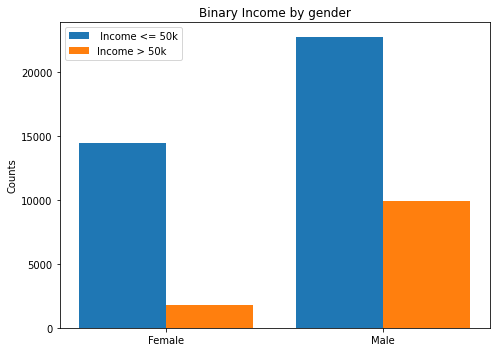

In [0]:
df = adult_dataset_orig.metadata['params']['df'].copy()
# Number of Men with Income <=50 k
male_less_50k = sum(df[((df['sex'] == 1.0))]['Income Binary'] == 0.0)

# Number of Men with Income >50 k
male_more_50k = sum(df[((df['sex'] == 1.0))]['Income Binary'] == 1.0)

# Number of Women with Income <=50 k
female_less_50k = sum(df[((df['sex'] == 0.0))]['Income Binary'] == 0.0)

# Number of women with Income >50 k
female_more_50k = sum(df[((df['sex'] == 0.0))]['Income Binary'] == 1.0)

print('Male')
print('<=50k:', male_less_50k,'\t>50k:', male_more_50k, '\tTotal:', male_less_50k + male_more_50k)
print('Female')
print('<=50k:', female_less_50k, '\t>50k:', female_more_50k, '\tTotal:', female_less_50k + female_more_50k)
print('\n\t\t\t\tTotal:', male_less_50k + male_more_50k + female_less_50k + female_more_50k)
# Plot a bar graph:
labels = ['Female', 'Male']
less_50k = [female_less_50k, male_less_50k]
more_50k = [female_more_50k, male_more_50k]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(x - width/2, less_50k, width, label=' Income <= 50k')
rects2 = ax.bar(x + width/2, more_50k, width, label='Income > 50k')

ax.set_ylabel('Counts')
ax.set_title('Binary Income by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Split Audult Dataset into training(60%) and test data(40%):

In [0]:
ad_train, ad_test = adult_dataset_orig.split([0.6], shuffle=True)

In [0]:
# Preprocess data
scale_orig = StandardScaler()

X_train = scale_orig.fit_transform(ad_train.features)
y_train = ad_train.labels.ravel()

X_test = scale_orig.transform(ad_test.features)
y_test = ad_test.labels.ravel()

Create a Logistic Regression class with pytorch:

In [0]:
class LogisticRegression_torch(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
BATCH_SIZE = 32
learning_rate = 0.0001

# Create a DataTensor
train_dataset = Data.TensorDataset(torch.tensor(X_train).float(), torch.Tensor(y_train).float())

if device == 0:
    num_workers = 2
else:
    num_workers = 0

# Data Loader
loader_train = Data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=num_workers)

Train a LR-model for each regularization parameter $\lambda$ and test on the test set:

In [0]:
criterion = torch.nn.BCELoss(reduction='sum')
epochs = 3
accuracies = []
metrics = {}
lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
lambdas = np.concatenate((np.array(lambdas), np.linspace(1, 100, num=100)))
for reg_lambda in lambdas:
    print('Lambda:', reg_lambda,'\n')
    model = LogisticRegression_torch(X_train.shape[1], 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)  
    for epoch in range(epochs):
        train_loss = 0.0
        for i, (x, y) in enumerate(loader_train):
            
        # Converting inputs and labels to Variable

            inputs = Variable(x.to(device))
            labels = Variable(y.to(device))

            # Clear gradient buffers because we don't want any gradient 
            # from previous epoch to carry forward, dont want to cummulate gradients
            optimizer.zero_grad()

            # get output from the model, given the inputs
            outputs = model(inputs)

            # Regularization
            reg = 0
            for param in model.parameters():
                reg += 0.5 * (param ** 2).sum()

            # get loss for the predicted output
            loss = criterion(outputs.reshape(outputs.shape[0]), labels) + \
                reg_lambda * reg
                
            train_loss += loss.item()
            
            # get gradients w.r.t to parameters
            loss.backward()
            
            # update parameters
            optimizer.step()
        

        print('epoch [{}/{}], Training loss:{:.6f}'.format(
            epoch + 1, 
            epochs, 
            train_loss / len(loader_train.dataset)))
    with torch.no_grad():
        model.eval()
        out = model(Variable(torch.Tensor(X_test).to(device))).detach().cpu()
        pred = (out >= 0.5).int().numpy().squeeze()
        accuracy = sum((y_test == pred))/len(y_test)
    

    print('Accuracy: ', accuracy,'\n')
    accuracies.append(accuracy)

    test_pred = ad_test.copy()
    test_pred.labels = pred.reshape(-1,1)
    metric = ClassificationMetric(ad_test, test_pred,unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metrics[reg_lambda] = {}
    metrics[reg_lambda]['accuracy'] = accuracy
    metrics[reg_lambda]['privilaged'] = metric.performance_measures(privileged=True)
    metrics[reg_lambda]['unprivilaged'] = metric.performance_measures(privileged=False)

    met = metric.binary_confusion_matrix(privileged=True)
    PR_priv = (met['TP'] + met['FP']) / (met['TP'] + met['FP'] + met['TN'] + met['FN'])
    metrics[reg_lambda]['privilaged']['PR'] = PR_priv

    met = metric.binary_confusion_matrix(privileged=False)
    PR_unpriv = (met['TP'] + met['FP']) / (met['TP'] + met['FP'] + met['TN'] + met['FN'])
    metrics[reg_lambda]['unprivilaged']['PR'] = PR_unpriv


Plot accuracy with respect to $\lambda$:

Text(0, 0.5, 'Accuracy')

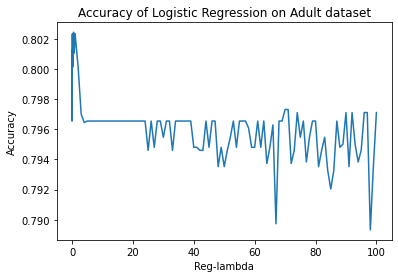

In [0]:
plt.plot(lambdas, accuracies)
plt.title('Accuracy of Logistic Regression on Adult dataset')
plt.xlabel('Reg-lambda')
plt.ylabel('Accuracy')

Plot TPR and NPR for each sensitive class with respect to $\lambda$:




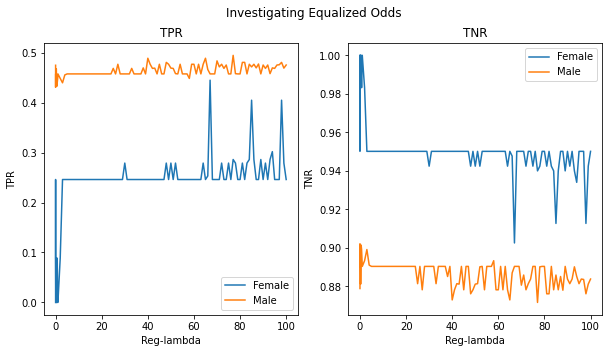

In [0]:
TPR_priv = []
TPR_non_priv = []
TNR_priv = []
TNR_non_priv = []
for l in metrics:
    TPR_priv.append(metrics[l]['privilaged']['TPR'])
    TPR_non_priv.append(metrics[l]['unprivilaged']['TPR'])
    TNR_priv.append(metrics[l]['privilaged']['TNR'])
    TNR_non_priv.append(metrics[l]['unprivilaged']['TNR'])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Investigating Equalized Odds')
axs[0].plot(lambdas, TPR_non_priv)
axs[0].plot(lambdas, TPR_priv)
axs[0].set_title('TPR')
axs[0].set(xlabel='Reg-lambda', ylabel='TPR')
axs[0].legend(['Female', 'Male'])

axs[1].plot(lambdas, TNR_non_priv)
axs[1].plot(lambdas, TNR_priv)
axs[1].set_title('TNR')
axs[1].set(xlabel='Reg-lambda', ylabel='TNR')
axs[1].legend(['Female', 'Male'])

Plot positive and negative predictive parity for each sensitive class with respect to $\lambda$:


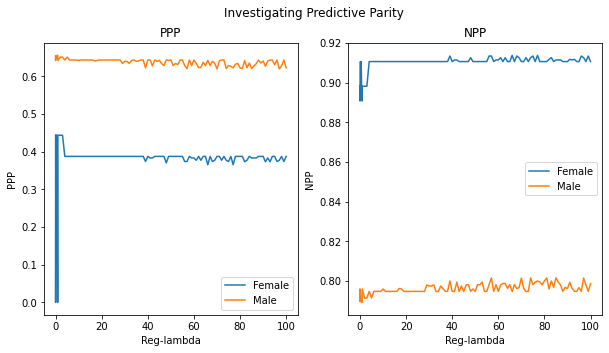

In [0]:
PPP_priv= []
PPP_non_priv= []
NPP_priv= []
NPP_non_priv = []
for l in metrics:
    PPP_priv.append(metrics[l]['privilaged']['PPV'])
    PPP_non_priv.append(metrics[l]['unprivilaged']['PPV'])
    NPP_priv.append(metrics[l]['privilaged']['NPV'])
    NPP_non_priv.append(metrics[l]['unprivilaged']['NPV'])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Investigating Predictive Parity')
axs[0].plot(lambdas, PPP_non_priv)
axs[0].plot(lambdas, PPP_pri)
axs[0].set_title('PPP')
axs[0].set(xlabel='Reg-lambda', ylabel='PPP')
axs[0].legend(['Female', 'Male'])

axs[1].plot(lambdas, NPP_non_priv)
axs[1].plot(lambdas, NPP_priv)
axs[1].set_title('NPP')
axs[1].set(xlabel='Reg-lambda', ylabel='NPP')
axs[1].legend(['Female', 'Male'])

Plot PR for each sensitive class with respect to $\lambda$:


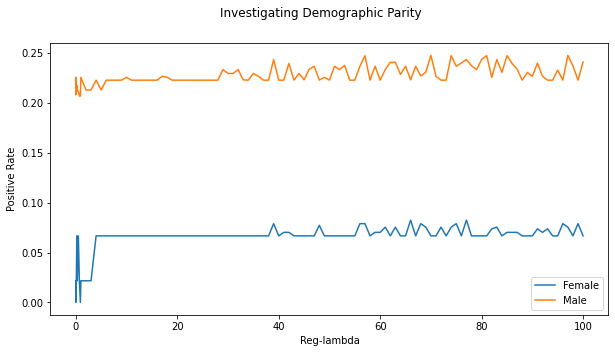

In [0]:
PR_priv = []
PR_non_priv = []
for l in metrics:
    PR_priv.append(metrics[l]['privilaged']['PR'])
    PR_non_priv.append(metrics[l]['unprivilaged']['PR'])

fig, axs = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Investigating Demographic Parity')
axs.plot(lambdas, PR_non_priv)
axs.plot(lambdas, PR_priv)
axs.set(xlabel='Reg-lambda', ylabel='Positive Rate')
axs.legend(['Female', 'Male'])

### Pre-processing by Reweighing:

In [0]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)

ad_train_rw = RW.fit_transform(ad_train)

In [0]:
# Create a weights Tensor
weights = torch.FloatTensor(ad_train_rw.instance_weights)

BATCH_SIZE = 32
learning_rate = 0.0001

# Data Tensor
# We now include the weights so that data will be reweighed during training
rw_train_dataset = Data.TensorDataset(torch.tensor(X_train).float(), 
                                      torch.Tensor(y_train).float(), 
                                      weights)
# Data Loader
loader_train = Data.DataLoader(
    dataset=rw_train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=num_workers)

Train a LR-model for each regularization parameter $\lambda$ and test on the test set:

In [0]:
epochs = 3
accuracies = []
metrics_rw = {}
lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
lambdas = np.concatenate((np.array(lambdas), np.linspace(1, 100, num=100)))
for reg_lambda in lambdas:
    model = LogisticRegression_torch(X_train.shape[1], 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    for epoch in range(epochs):
        train_loss = 0.0
        for i, (x, y, w) in enumerate(loader_train):
        # Converting inputs and labels to Variable

            inputs = Variable(x.to(device))
            labels = Variable(y.to(device))

            # Clear gradient buffers because we don't want any gradient 
            # from previous epoch to carry forward, dont want to cummulate gradients
            optimizer.zero_grad()

            # get output from the model, given the inputs
            outputs = model(inputs)

            # Regularization
            reg = 0
            for param in model.parameters():
                reg += 0.5 * (param ** 2).mean()
                #reg += param.abs().sum()
            # reg_lambda = 0
            
            # criterion
            criterion = torch.nn.BCELoss(weight=w, reduction='sum')
            # get loss for the predicted output
            loss = criterion(outputs.reshape(outputs.shape[0]), labels) + \
                reg_lambda * reg
            
                
            train_loss += loss.item()
            
            # get gradients w.r.t to parameters
            loss.backward()
            
            # update parameters
            optimizer.step()
        

        print('epoch [{}/{}], Training loss:{:.6f}'.format(
            epoch + 1, 
            epochs, 
            train_loss / len(loader_train.dataset)))
    with torch.no_grad():
        model.eval()
        out = model(Variable(torch.Tensor(X_test).to(device))).detach().cpu()
        pred = (out >= 0.5).int().numpy().squeeze()
        accuracy = sum((y_test == pred))/len(y_test)
        print('Accuracy: ', accuracy)
        accuracies.append(accuracy)

    test_pred = ad_test.copy()
    test_pred.labels = pred.reshape(-1,1)
    metric_rew = ClassificationMetric(ad_test, test_pred,unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    
    
    metrics_rw[reg_lambda] = {}
    metrics_rw[reg_lambda]['accuracy'] = accuracy
    metrics_rw[reg_lambda]['privilaged'] = metric_rew.performance_measures(privileged=True)
    metrics_rw[reg_lambda]['unprivilaged'] = metric_rew.performance_measures(privileged=False)

    met = metric_rew.binary_confusion_matrix(privileged=True)
    PR_priv = (met['TP'] + met['FP']) / (met['TP'] + met['FP'] + met['TN'] + met['FN'])
    metrics_rw[reg_lambda]['privilaged']['PR'] = PR_priv

    met = metric_rew.binary_confusion_matrix(privileged=False)
    PR_unpriv = (met['TP'] + met['FP']) / (met['TP'] + met['FP'] + met['TN'] + met['FN'])
    metrics_rw[reg_lambda]['unprivilaged']['PR'] = PR_unpriv

Plot accuracy with respect to $\lambda$:

Text(0, 0.5, 'Accuracy')

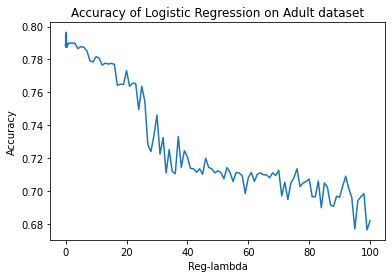

In [0]:
plt.plot(lambdas, accuracies)
plt.title('Accuracy of Logistic Regression on Adult dataset')
plt.xlabel('Reg-lambda')
plt.ylabel('Accuracy')

Plot TPR and NPR for each sensitive class with respect to $\lambda$:


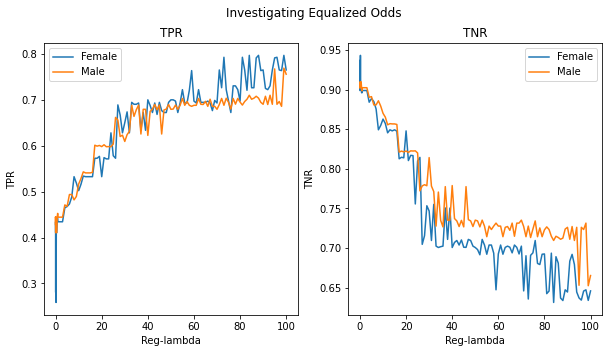

In [0]:
TPR_priv_rw = []
TPR_non_priv_rw = []
TNR_priv_rw = []
TNR_non_priv_rw = []
for l in metrics_rw:
    TPR_priv_rw.append(metrics_rw[l]['privilaged']['TPR'])
    TPR_non_priv_rw.append(metrics_rw[l]['unprivilaged']['TPR'])
    TNR_priv_rw.append(metrics_rw[l]['privilaged']['TNR'])
    TNR_non_priv_rw.append(metrics_rw[l]['unprivilaged']['TNR'])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Investigating Equalized Odds')
axs[0].plot(lambdas, TPR_non_priv_rw)
axs[0].plot(lambdas, TPR_priv_rw)
axs[0].set_title('TPR')
axs[0].set(xlabel='Reg-lambda', ylabel='TPR')
axs[0].legend(['Female', 'Male'])

axs[1].plot(lambdas, TNR_non_priv_rw)
axs[1].plot(lambdas, TNR_priv_rw)
axs[1].set_title('TNR')
axs[1].set(xlabel='Reg-lambda', ylabel='TNR')
axs[1].legend(['Female', 'Male'])


Plot PPP and NPP for each sensitive class with respect to $\lambda$:


[(0.2, 1.0)]

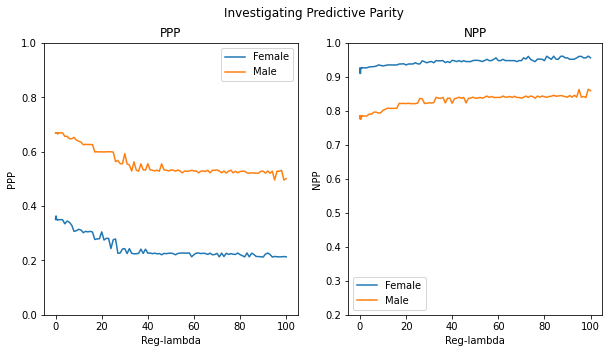

In [0]:
PPP_priv_rw = []
PPP_non_priv_rw = []
NPP_priv_rw = []
NPP_non_priv_rw = []
for l in metrics_rw:
    PPP_priv_rw.append(metrics_rw[l]['privilaged']['PPV'])
    PPP_non_priv_rw.append(metrics_rw[l]['unprivilaged']['PPV'])
    NPP_priv_rw.append(metrics_rw[l]['privilaged']['NPV'])
    NPP_non_priv_rw.append(metrics_rw[l]['unprivilaged']['NPV'])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Investigating Predictive Parity')
axs[0].plot(lambdas, PPP_non_priv_rw)
axs[0].plot(lambdas, PPP_priv_rw)
axs[0].set_title('PPP')
axs[0].set(xlabel='Reg-lambda', ylabel='PPP')
axs[0].legend(['Female', 'Male'])
axs[0].set(ylim=(0,1))

axs[1].plot(lambdas, NPP_non_priv_rw)
axs[1].plot(lambdas, NPP_priv_rw)
axs[1].set_title('NPP')
axs[1].set(xlabel='Reg-lambda', ylabel='NPP')
axs[1].legend(['Female', 'Male'])
axs[1].set(ylim=(0.2,1))

Plot PR for each sensitive class with respect to $\lambda$:


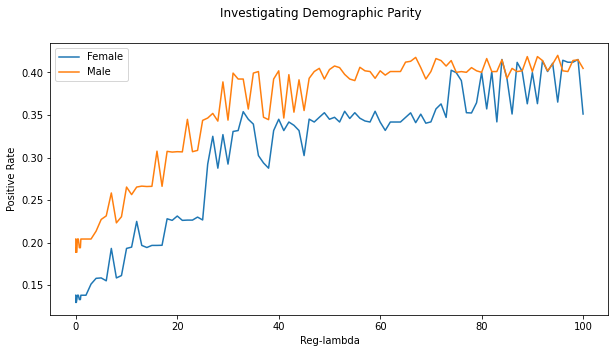

In [0]:
PR_priv_rw = []
PR_non_priv_rw = []
for l in metrics_rw:
    PR_priv_rw.append(metrics_rw[l]['privilaged']['PR'])
    PR_non_priv_rw.append(metrics_rw[l]['unprivilaged']['PR'])

fig, axs = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Investigating Demographic Parity')
axs.plot(lambdas, PR_non_priv_rw)
axs.plot(lambdas, PR_priv_rw)
axs.set(xlabel='Reg-lambda', ylabel='Positive Rate')
axs.legend(['Female', 'Male'])